# Advanced Lane Finding Project

The tasks to accomplish in this project are as following:

 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
 2. Apply a distortion correction to raw images.
 3. Use color transforms, gradients, etc., to create a thresholded binary image.
 4. Apply a perspective transform to rectify binary image ("birds-eye view").
 5. Detect lane pixels and fit to find the lane boundary.
 6. Determine the curvature of the lane and vehicle position with respect to center.
 7. Warp the detected lane boundaries back onto the original image.
 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
# Import necessary packages
import os
import numpy as np
import glob # to read files from dir
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

os.getcwd()

'C:\\Jandal\\workspace_P\\UNDSC\\CarND-Advanced-Lane-Lines'

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
The solution can be found in <font color=blue>1_Camera_Calibration.ipynb</font> notebook in this directory.

### 2 - 4 steps 
The solution can be found in <font color=blue>Stage1_Pipeline_a.ipynb</font> notebook in this directory.

### 5. Detect lane pixels and fit to find the lane boundary.

In [2]:
# Reading camera calibration variables from pickle object
path_dir = os.getcwd()+"\\pickled_data\\"
pickle_obj = pickle.load(open(path_dir+"camera_calibration.p", "rb" ))
mtx = pickle_obj["mtx"]
dist = pickle_obj["dist"]

# Reading wrapped image from previous notebook using pickle
path_dir = os.getcwd()+"\\pickled_data\\"
pickle_obj = pickle.load(open(path_dir+"result_images.p", "rb" ))
original_image = pickle_obj["original_image"]
combined_img = pickle_obj["combined_img"]
warpPerspective = pickle_obj["warpPerspective"]

In [3]:
# Required functions from previous notebook
# Visualization function to be used in the following stages
def plot_the_result(original_image,result_img,t1="Original Image", t2="Thresholded"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
    f.tight_layout()
    ax1.imshow(original_image)
    ax1.set_title(t1, fontsize=30)
    ax2.imshow(result_img, cmap='gray')
    ax2.set_title(t2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

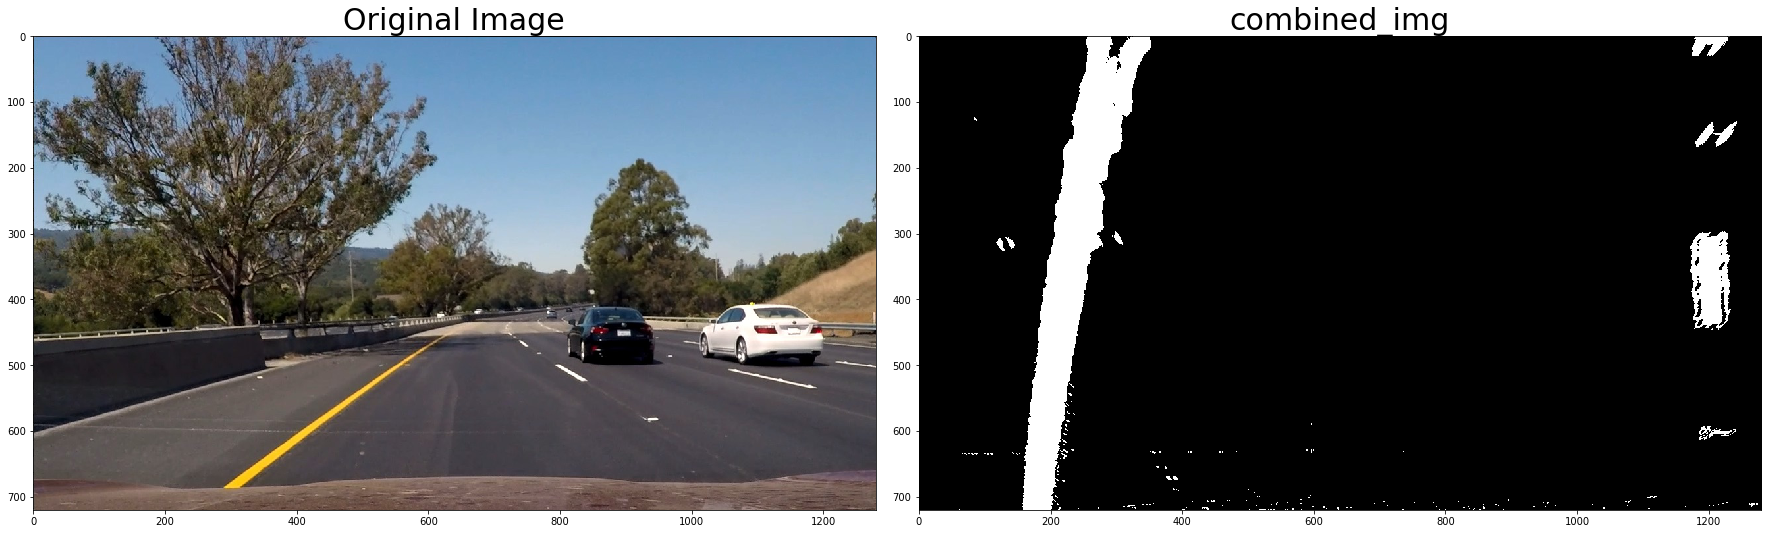

In [4]:
# Plotting combined thresholded image of the warpped perspective 
combined_img = cv2.cvtColor(combined_img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
plot_the_result(original_image, combined_img, t2="combined_img")

#### Line Finding Method: Peaks in a Histogram

Left & Right peaks =  (195, 1200.0)


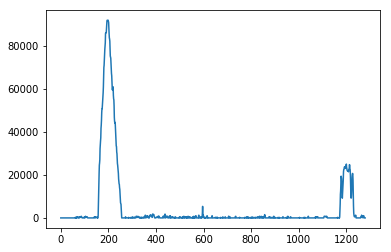

In [5]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

def get_histogram_peaks(binary_warped, bottom_pct=0.5):
    # bottom_pct: How much of the bottom to use for initial tracer placement

    shape = binary_warped.shape

    bottom_sect = binary_warped[-int(bottom_pct*shape[0]):, :]

    left_peak = bottom_sect[:, :int(0.5*shape[1])].sum(axis=0).argmax()
    right_peak = bottom_sect[:, int(0.5*shape[1]):].sum(axis=0).argmax() + 0.5*shape[1]

    # Return x-position of the two peaks
    return left_peak, right_peak

# Create histogram of image binary activations

print("Left & Right peaks = ", get_histogram_peaks(combined_img))
histogram = hist(combined_img)

# Visualize the resulting histogram
plt.plot(histogram)

#### Sliding Windows to detect lane pixels

Left Polygon (left_fit)   =  [ 1.38688366e-04 -2.74106696e-01  3.05344619e+02]
Right Polygon (right_fit) =  [-1.49314535e-06  2.26973975e-03  1.20131058e+03]


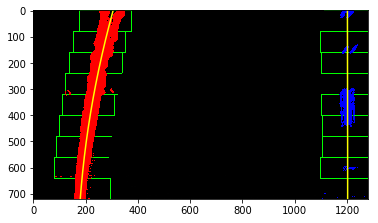

In [6]:
# Implement Sliding Windows and Fit a Polynomial
def get_sliding_windows(binary_warped,nwindows = 9,margin = 100,minpix = 50):
    left_peak, right_peak = get_histogram_peaks(binary_warped)
    histogram = hist(binary_warped)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit

def visualize_lanes_slidingWindows(slidingWindows, left_fitx, right_fitx, ploty):
    # Plot the polynomial lines onto the image
    plt.imshow(slidingWindows)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

# Hyper parameters
nWINDOWS = 9
MARGIN = 100
minPIX = 50

# Getting sliding windows and left,right polygons
slidingWindows,left_fitx,right_fitx,ploty,left_fit,right_fit = get_sliding_windows(combined_img,
                                                                                  nWINDOWS,MARGIN,minPIX)

# Visualize left, right lanes with sliding windows
visualize_lanes_slidingWindows(slidingWindows, left_fitx, right_fitx, ploty)

print("Left Polygon (left_fit)   = ", left_fit)
print("Right Polygon (right_fit) = ", right_fit)

#### Alternative & better way to smoothly find lane pixels

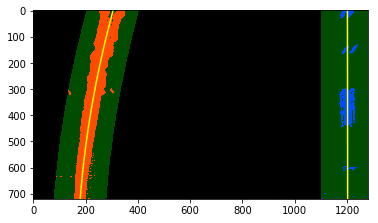

In [7]:
# Getting smooth lanes
def get_smooth_lanes(binary_warped, margin, left_fit, right_fit):

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    img_shape = binary_warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx, ploty

def visualize_smooth_lanes(smoothLanes, left_fitx, right_fitx, ploty):
    # Plot the polynomial lines onto the image
    plt.imshow(smoothLanes)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

# Hyper parameters, using previous left_fit, right_fit values
MARGIN = 100
left_fit = np.array([1.38688366e-04,-2.74106696e-01,3.05344619e+02])
right_fit = np.array([-1.49314535e-06,2.26973975e-03,1.20131058e+03])

# Getting smooth lanes instead of sliding windows
smoothLanes, left_fitx, right_fitx, ploty = get_smooth_lanes(combined_img, MARGIN, left_fit, right_fit)

# Visualize smooth lanes
visualize_smooth_lanes(smoothLanes,left_fitx,right_fitx,ploty)

### 6. Determine the curvature of the lane and vehicle position with respect to center.

In [8]:
def measure_curvature_pixels(binary_warped, left_fit, right_fit, margin):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    img_shape = binary_warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Initial hyperparams
left_fit = np.array([ 1.32097979e-04,-2.64637457e-01,3.02348466e+02])
right_fit = np.array([2.57272512e-07,1.42218646e-03,1.20140758e+03])
margin = 100
    
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(combined_img, left_fit, right_fit, margin)

print(left_curverad, right_curverad)

3763.5232933710304 334863.59009052167


#### Curvature of polynomial functions in meters

In [9]:
def get_realRadiusOfCurvature(binary_warped,left_fit,right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    carPosition = binary_warped.shape[1]/2
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    y_eval=np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actualPosition = (left_lane_bottom + right_lane_bottom)/2
    
    distance = (carPosition - actualPosition)* xm_per_pix
    
    return (left_curverad + right_curverad)/2, distance

# Calling function
# Initial hyperparams
left_fit = np.array([ 1.32097979e-04,-2.64637457e-01,3.02348466e+02])
right_fit = np.array([2.57272512e-07,1.42218646e-03,1.20140758e+03])

left_curverad, right_curverad = get_realRadiusOfCurvature(combined_img,left_fit,right_fit)
print(left_curverad, 'm', right_curverad, 'm')

319790.5352064033 m -0.5916306088229227 m


### 7. Warp the detected lane boundaries back onto the original image.

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [10]:
# Unwarpping the image
def unwarp_image(original_image, binary_warped, left_fit, right_fit, dst, src):
    h,w = binary_warped.shape
    Minv = cv2.getPerspectiveTransform(dst, src) # inverse perspective transformation
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, h-1, num = h)# to cover same y-range as image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 

    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result

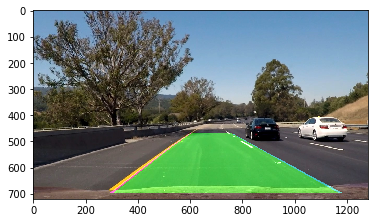

In [11]:
# Calling unwarp()
# Getting src & dst from previous notebook
src = np.float32([[550, 470], [760, 470], [1125, 670], [200, 670]])
dst = np.float32([[10, 10], [1200, 10], [1200, 700], [10, 700]])
unwarppedImage = unwarp_image(original_image,combined_img,left_fit,right_fit,dst,src)
plt.imshow(unwarppedImage)